In [40]:
import torch
import torchvision
from torch import nn
from torch import optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms

In [41]:
class Critic(nn.Module):
    def __init__(self,channels_img,features_d,num_classes,img_size):
        super().__init__()
        self.img_size=img_size
        self.disc=nn.Sequential(
            #Input : N* channels_img*64*64
            nn.Conv2d(in_channels=channels_img+1,out_channels=features_d,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            self._block(in_channels=features_d,out_channels=features_d*2,kernel_size=4,stride=2,padding=1),
            self._block(in_channels=features_d*2,out_channels=features_d*4,kernel_size=4,stride=2,padding=1),
            self._block(in_channels=features_d*4,out_channels=features_d*8,kernel_size=4,stride=2,padding=1),
            nn.Conv2d(in_channels=features_d*8,out_channels=1,kernel_size=4,stride=2,padding=0),
        
        )
        self.embed=nn.Embedding(num_classes,img_size*img_size)

    
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),
            nn.InstanceNorm2d(out_channels,affine=True),   #LayerNorm ->Instance Norm
            nn.LeakyReLU(0.2)
        )
    def forward(self,x,labels):
        embedding=self.embed(labels).view(labels.shape[0],1,self.img_size,self.img_size)
        x=torch.cat([x,embedding],dim=1)
        return self.disc(x)

In [42]:
class Generator(nn.Module):
    def __init__(self,channels_noise,channels_img,features_g,num_classes,img_size,embed_size):
        super().__init__()
        self.img_size=img_size
        self.gen=nn.Sequential(
            #Input: N*z_dim*1*1
            self._block(in_channels=channels_noise+embed_size,out_channels=features_g*16,kernel_size=4,stride=1,padding=0), #N*features_g*16*4*4
            self._block(in_channels=features_g*16,out_channels=features_g*8,kernel_size=4,stride=2,padding=1), # 8*8
            self._block(in_channels=features_g*8,out_channels=features_g*4,kernel_size=4,stride=2,padding=1), #16*16
            self._block(in_channels=features_g*4,out_channels=features_g*2,kernel_size=4,stride=2,padding=1), #32*32
            nn.ConvTranspose2d(in_channels=features_g*2,out_channels=channels_img,kernel_size=4,stride=2,padding=1),
            nn.Tanh() # [-1,1]
        )
        self.embed=nn.Embedding(num_classes,embed_size)

    
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self,X,labels):
        ##Latent vector: N*noise_dim*1*1
        embedding=self.embed(labels).unsqueeze(2).unsqueeze(3)
        X=torch.cat([X,embedding],dim=1)
        return self.gen(X)
        

In [43]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02)
      

In [44]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device:{device}")

Using device:cuda


In [45]:
def gradient_penalty(critic,labels,real,fake,device="gpu"):
    BATCH_SIZE,C,H,W=real.shape
    epsilon=torch.rand((BATCH_SIZE,1,1,1)).repeat(1,C,H,W).to(device)
    interpolated_images=real*epsilon + fake*(1-epsilon)
    ##Calculate the critic scores
    mixed_score=critic(interpolated_images,labels)
    gradient=torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_score,
        grad_outputs=torch.ones_like(mixed_score),
        create_graph=True,
        retain_graph=True
        
    )[0]
    gradient=gradient.view(gradient.shape[0],-1)   #Flatten
    gradient_norm=gradient.norm(2,dim=1)
    gradient_penalty=torch.mean((gradient_norm-1)**2)
    return gradient_penalty

In [46]:
LEARNING_RATE=1e-4
BATCH_SIZE=64
IMAGE_SIZE=64
CHANNELS_IMG=1
NUM_CLASSES=10
GEN_EMBEDDING=100
Z_DIM=100
NUM_EPOCHS=10
FEATURES_DISC=64
FEATURES_GEN=64
CRITIC_ITERATIONS=5
LAMBDA_GP=10

transforms=transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)],[0.5 for _ in range(CHANNELS_IMG)])
])

In [47]:
dataset=datasets.MNIST(root='dataset',train=True,transform=transforms,target_transform=None,download=True)
dataloader=DataLoader(dataset=dataset,batch_size=BATCH_SIZE,shuffle=True)


In [48]:
gen=Generator(channels_noise=Z_DIM,channels_img=CHANNELS_IMG,features_g=FEATURES_GEN,num_classes=NUM_CLASSES,img_size=IMAGE_SIZE,embed_size=GEN_EMBEDDING).to(device)
critic=Critic(channels_img=CHANNELS_IMG,features_d=FEATURES_DISC,num_classes=NUM_CLASSES,img_size=IMAGE_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)


In [49]:
opt_gen=optim.Adam(params=gen.parameters(),lr=LEARNING_RATE,betas=(0.0,0.9))
opt_critic=optim.Adam(params=critic.parameters(),lr=LEARNING_RATE,betas=(0.0,0.9))



In [50]:
fixed_noise=torch.randn(BATCH_SIZE,Z_DIM,1,1).to(device)
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step=0
gen.train()
critic.train()


Critic(
  (disc): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
  (embed): Embedding(10, 4096)

In [51]:
for epoch in range(NUM_EPOCHS):
    for batch_idx,(real,labels) in enumerate(dataloader):
        real=real.to(device)
        cur_batch_size=real.shape[0]
        labels=labels.to(device)
        for _ in range(CRITIC_ITERATIONS):
            noise=torch.randn((cur_batch_size,Z_DIM,1,1)).to(device)
            fake=gen(noise,labels).to(device)
            if fake.shape[0] != real.shape[0]:  # Adjust batch size if necessary
                fake = fake[:real.shape[0]]
            critic_real=critic(real,labels).reshape(-1)
            critic_fake=critic(fake.detach(),labels).reshape(-1)
            gp=gradient_penalty(critic,labels,real,fake,device=device)
            loss_critic=-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP*gp  ##Adding - sign coz we want to maximize this eqn instead of bydefault minimize
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

           


        ##Train generator: min -E(critic(gen_fake))
        output=critic(fake,labels).reshape(-1)
        loss_gen=-torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise,labels)
               
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1


                

Epoch [0/10] Batch 0/938                   Loss D: -7.9580, loss G: 6.9428
Epoch [0/10] Batch 100/938                   Loss D: -102.0464, loss G: 101.2569
Epoch [0/10] Batch 200/938                   Loss D: -72.7225, loss G: 92.6691
Epoch [0/10] Batch 300/938                   Loss D: -44.6831, loss G: 82.5431
Epoch [0/10] Batch 400/938                   Loss D: -29.1928, loss G: 86.1714
Epoch [0/10] Batch 500/938                   Loss D: -18.5023, loss G: 90.0573
Epoch [0/10] Batch 600/938                   Loss D: -15.8315, loss G: 90.0282
Epoch [0/10] Batch 700/938                   Loss D: -10.4630, loss G: 87.9858
Epoch [0/10] Batch 800/938                   Loss D: -11.0752, loss G: 82.9174
Epoch [0/10] Batch 900/938                   Loss D: -9.0463, loss G: 89.3653
Epoch [1/10] Batch 0/938                   Loss D: -9.6924, loss G: 88.1219
Epoch [1/10] Batch 100/938                   Loss D: -9.4370, loss G: 88.9566
Epoch [1/10] Batch 200/938                   Loss D: -10.80

KeyboardInterrupt: 

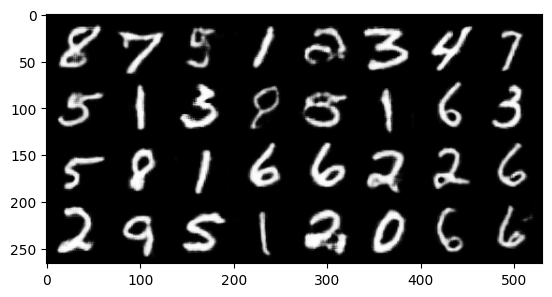

In [53]:
import matplotlib.pyplot as plt


plt.imshow(img_grid_fake.cpu().permute(1,2,0))

In [54]:
labels=torch.arange(0,10)

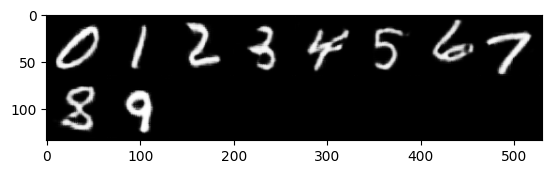

In [56]:
with torch.inference_mode():
    output = gen(torch.randn(10,100,1,1).to(device),labels.to(device))
    output = torchvision.utils.make_grid(output, normalize=True)
    plt.imshow(output.cpu().permute(1,2,0),cmap='gray')